# Counting Nuclei in DAPI stained and Propidium Iodide stained microscopy images

Author(s): Lizbeth Cortez and Daniel Pintard
Experiment Start Time: September 15th 2025, 8:45 AM

Plan of action: implement preprocessing and segmentation methods for counting nuclei per image. May have to process 'dapi' and 'pi' images separately. I will create a data dictionary that stores nuclei counts per image. I am unsure if some of these dapi images are supposed to complement pi images?

In [2]:
# --- CONFIG Block --- 
import cv2 
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from skimage import measure, segmentation, filters, morphology
import os

## Read, Explore and process data

I'll try one image to start and then develop and automated pipeline surrounding whichever process works best for most of our images.

In [3]:
dirpath = "../data/in_data/2025-09-15/membrane_damage_6_16_2025/"

tst_img = cv2.imread(os.path.join(dirpath, 'ma1_1_dapi.tif'))

In [4]:
tst_img.shape

(960, 1280, 3)

In [5]:
tst_dapi = tst_img[:, :, 0] # extract blue channel from image

I loaded one of the images as a numpy array. I will now visualize what the blue channel (i.e. DAPI channel) looks like in greyscale just to take a look at it.

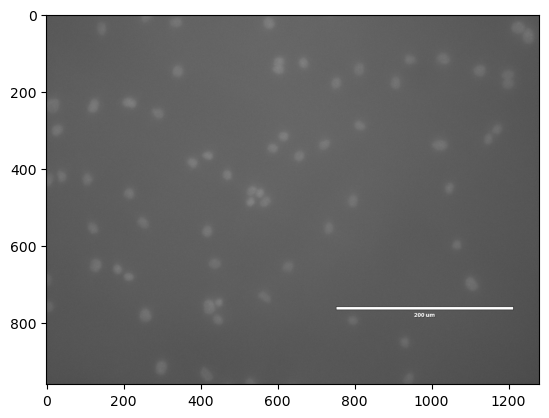

In [6]:
plt.imshow(tst_dapi, cmap='gray')
plt.show()

Note: Do we have metadata for these images that indicates the scaling ratio between pixels and microns. I.e. how many microns are in each pixel?

Used the following procedure in ImageJ to get scaling factor:
- use line tool to measure pixel length of scale bar in image (use Ctrl + M to measure after selection)
- divide scale bar length (200 µm) by measured distance to find out how many microns in 1 pixel

In [ ]:
pixel_to_um = 0.435 # um in 1 pixel, may or may not be needed later, but still valuable metadata

### Naive attempt at Otsu thresholding and binarizing image

In [8]:
ret1, thresh = cv2.threshold(tst_dapi, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # using Otsu's method for image segmentation

In [9]:
ret1

169.0

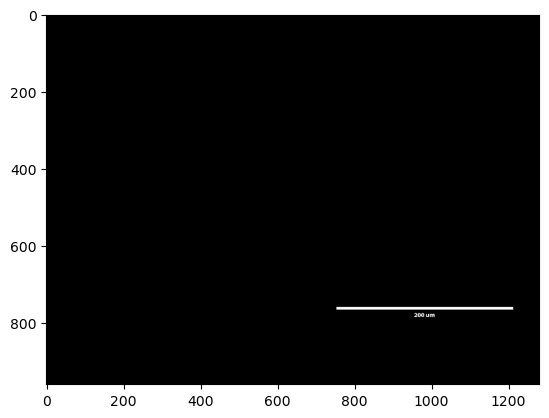

In [11]:
plt.imshow(thresh, cmap = 'gray')

In [12]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel, iterations = 2)

In [13]:
opening = segmentation.clear_border(opening)

In [14]:
sure_bg = cv2.dilate(opening,kernel,iterations=10)

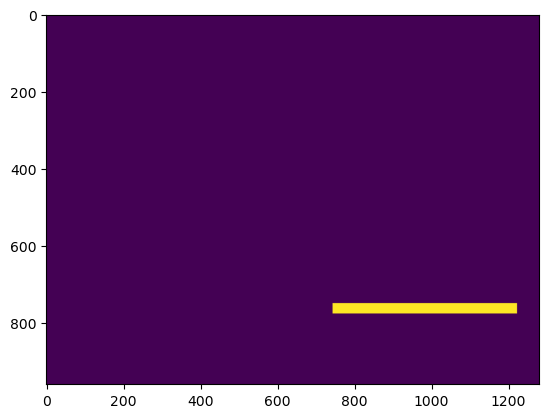

In [15]:
plt.imshow(sure_bg)

Uh oh, where are the nuclei? The segmentation didn't work. Otsu's method assumes a bimodal distribution in the image's pixel intensities, so let's check what the distribution of our image looks like.

In [16]:
hist = cv2.calcHist(tst_dapi, [0], None, [256], [0, 256])

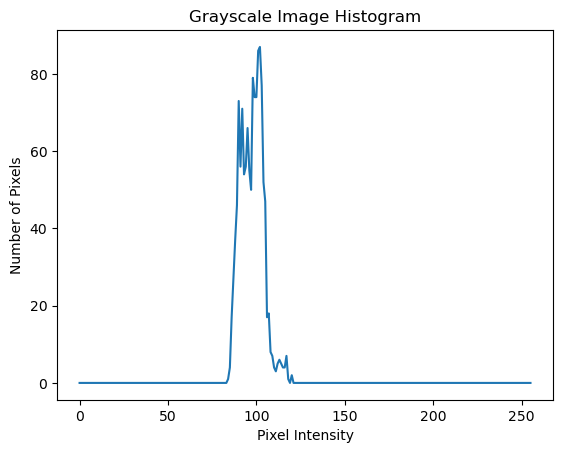

In [17]:
plt.plot(hist)
plt.title("Grayscale Image Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Number of Pixels")
plt.show()

Otsu's method assumes a bimodal distribution in the image data. I will need a different thresholding technique instead. Here, I'll try background subtraction before rerunning Otsu, to see if image processing can impact our result

#### Attempting background subtraction

In [18]:
tst_dapi_float = tst_dapi.astype(float)

In [19]:
tst_dapi_float

array([[90., 88., 88., ..., 87., 89., 89.],
       [90., 88., 88., ..., 86., 91., 87.],
       [89., 86., 89., ..., 86., 87., 89.],
       ...,
       [77., 77., 79., ..., 75., 72., 73.],
       [78., 77., 81., ..., 74., 77., 74.],
       [85., 82., 81., ..., 77., 78., 75.]], shape=(960, 1280))

In [20]:
bg = filters.gaussian(tst_dapi_float, sigma = 500) # gaussian blurring to create background representation

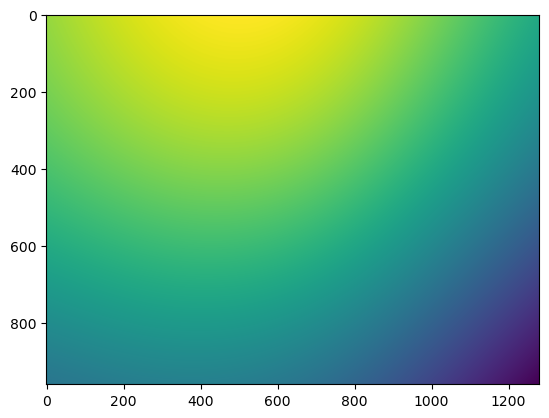

In [21]:
plt.imshow(bg)

In [22]:
subtracted_img = tst_dapi_float - bg

In [23]:
# normalize the image to standard range
subtracted_img = ((subtracted_img - subtracted_img.min()) / 
                  (subtracted_img.max() - subtracted_img.min()) * 255).astype(np.uint8)

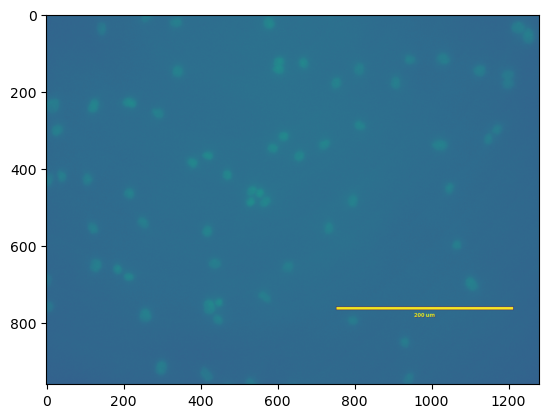

In [24]:
plt.imshow(subtracted_img)

This image doesn't really look any better, but let's try Otsu's method again?

In [25]:
ret2, thresh0 = cv2.threshold(subtracted_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [ ]:
ret2 # notice this threshold value is essentially the same as before +- 1

168.0

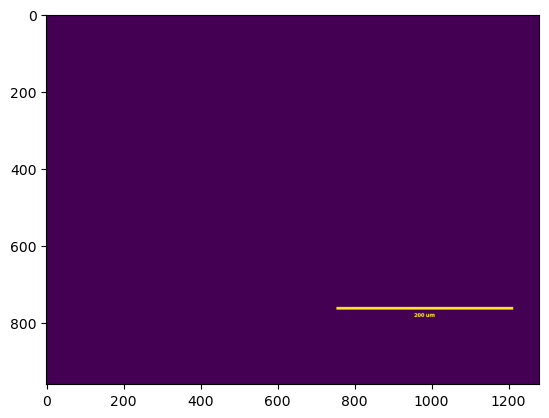

In [27]:
plt.imshow(thresh0)

nope, still doesn't work

### Let's try Top-hat transformation and then Otsu thresholding

In [28]:
selem = morphology.disk(20)
tophat_result = morphology.white_tophat(tst_dapi, selem)

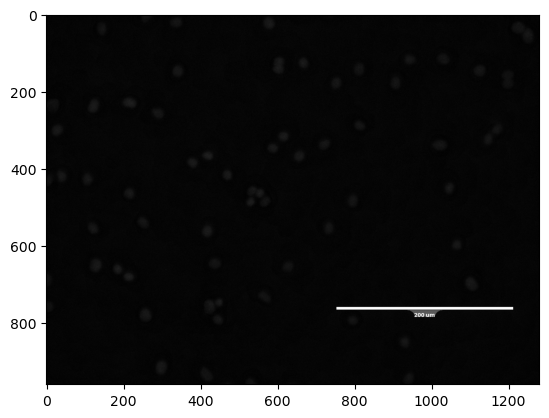

In [29]:
plt.imshow(tophat_result, cmap = 'gray')

In [30]:
thresh_value = filters.threshold_otsu(tophat_result)

In [31]:
bin_img = tophat_result > thresh_value

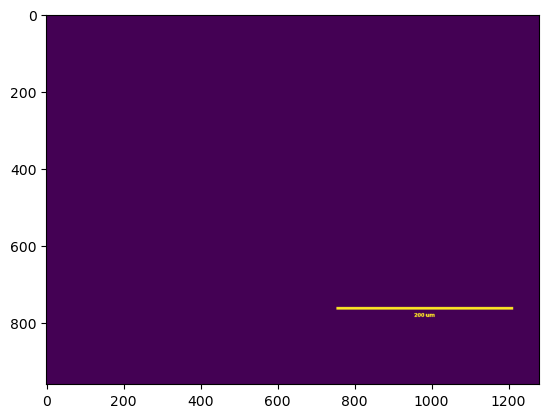

In [32]:
plt.imshow(bin_img)

Binarized image still shows no nuclei. Ok so I think that any attempt at Otsu or similar methods that assume bimodality is kind of a lost cause at this point.

### Trying adaptive thresholding

In [36]:
block_size = 51
C = -3

In [37]:
adapt_thresh = cv2.adaptiveThreshold(
    tst_dapi,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    block_size,
    C
)

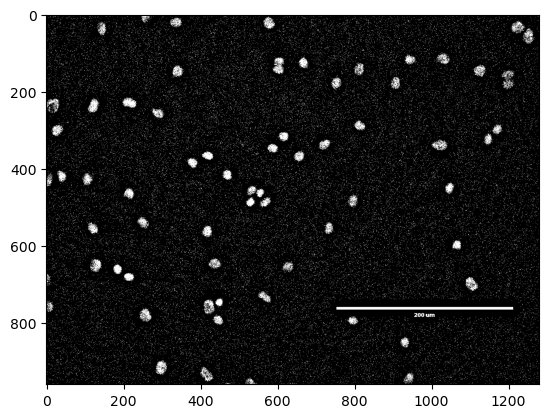

In [38]:
plt.imshow(adapt_thresh, cmap = 'gray')

In [39]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(adapt_thresh, cv2.MORPH_OPEN, kernel, iterations=1)

In [40]:
opening = segmentation.clear_border(opening)

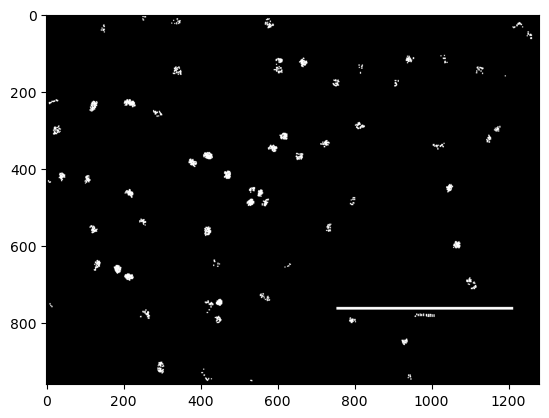

In [41]:
plt.imshow(opening, cmap = 'gray')

In [70]:
sure_bg = cv2.dilate(opening,kernel,iterations=9)

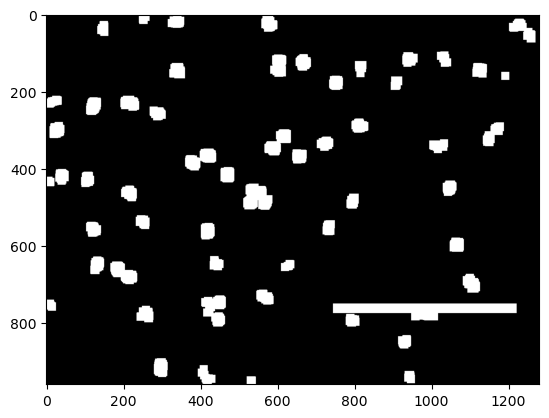

In [71]:
plt.imshow(sure_bg, cmap = 'gray') # identifying guaranteed background space in image

Seems like adaptive thresholding is the way to go! Ok, now there are two main concerns that I have looking at the resultant binarized image.

1) What to do about the scale bar? This will get in the way of any algorithmic method for qunatifying objects in a binarized image, so we need to get rid of it

2) You see that cluster of 4 nuclei near the center of the image? How will a segmentation method delineate these objects from one another?

### Getting rid of scale bar artefact

In [55]:
labeled_img = measure.label(sure_bg)

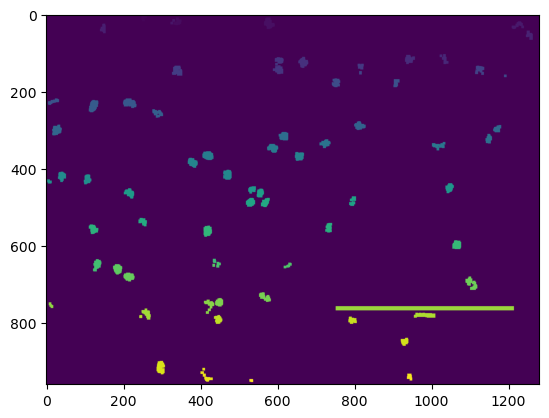

In [63]:
plt.imshow(labeled_img)

In [52]:
regions = measure.regionprops(labeled_img)

In [61]:
filtered_img = np.zeros_like(sure_bg)

for region in regions:
    if region.area < 100:
        filtered_img[labeled_img == region.label] = 1

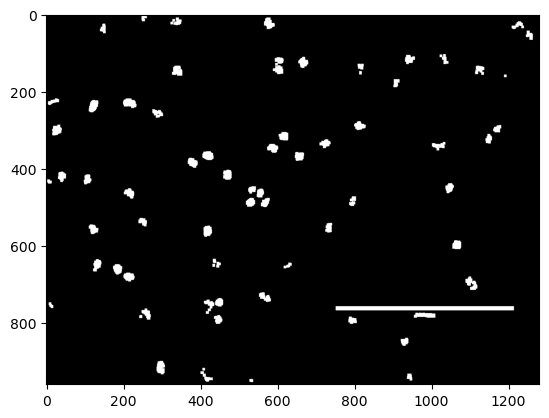

In [62]:
plt.imshow(filtered_img, cmap='gray')

ok so that worked! My worry now is what to do about the left over '200 µm' text in the image. I think when I quantify, I'll just subtract 1 from the final value.

Ok now we need to apply the watershed method to segment the nuclei.

In [201]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(filtered_img, cv2.MORPH_OPEN, kernel, iterations=1)

In [202]:
opening = segmentation.clear_border(opening)

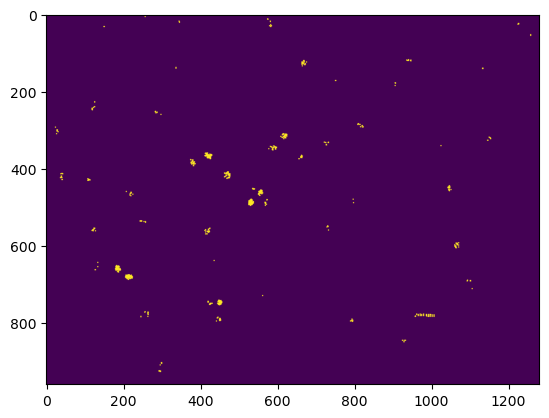

In [203]:
plt.imshow(opening)

In [210]:
sure_bg = cv2.dilate(opening,kernel,iterations=8)

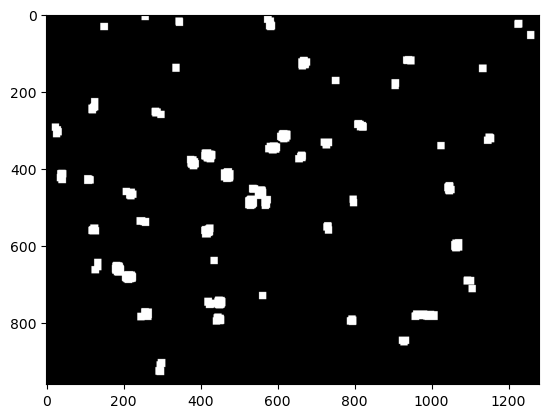

In [211]:
plt.imshow(sure_bg, cmap = 'gray')

In [212]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)

In [219]:
ret3, sure_fg = cv2.threshold(dist_transform, 0.1*dist_transform.max(),255,0)

In [220]:
sure_fg = np.uint8(sure_fg)

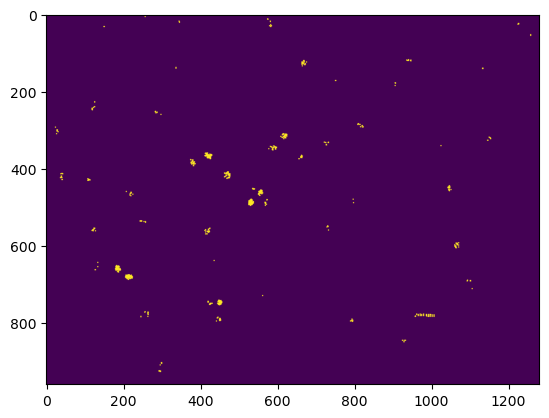

In [221]:
plt.imshow(sure_fg)

In [222]:
unknown_area = cv2.subtract(sure_bg, sure_fg)

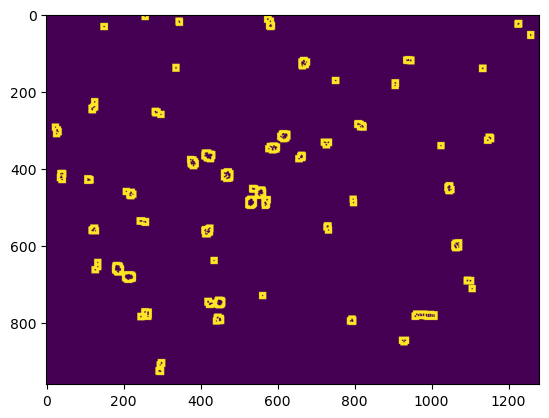

In [224]:
plt.imshow(unknown_area)

### Continue with watershed segmentation

In [72]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

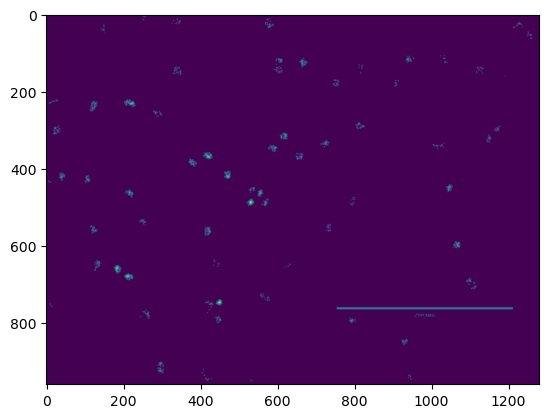

In [85]:
plt.imshow(dist_transform)

In [79]:
ret3, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)

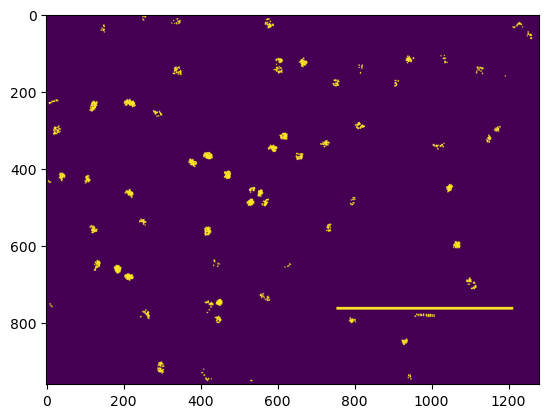

In [ ]:
plt.imshow(sure_fg, cmap = 'gray')

In [83]:
opening = cv2.morphologyEx(sure_fg, cv2.MORPH_OPEN, kernel, iterations=1)
sure_fg = cv2.dilate(opening,kernel,iterations=2)

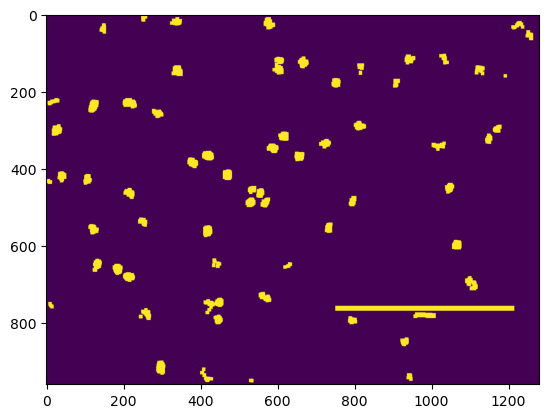

In [84]:
plt.imshow(sure_fg)